In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from astropy.timeseries import LombScargle


In [2]:
#read in all data available
#select data in band CV and with observer code trt

df=pd.read_csv("./aavsodata_20221112.txt")
df_vmt=df[(df["Band"] == "CV") & (df["Observer Code"] =="VMT")]
df_trt=df[(df["Band"] == "CV") & (df["Observer Code"] =="TRT")]


In [3]:
#extract useful data from df
JD_vmt=np.array(df_vmt["JD"])
Mag_vmt=np.array(pd.to_numeric(df_vmt["Magnitude"]))
JD_trt=np.array(df_trt["JD"])
Mag_trt=np.array(pd.to_numeric(df_trt["Magnitude"]))


In [4]:
#select basepoint of JD

JD_0 = 2.45971e6
JD_vmt=JD_vmt-JD_0
JD_trt=JD_trt-JD_0

Text(0, 0.5, 'CV Mag')

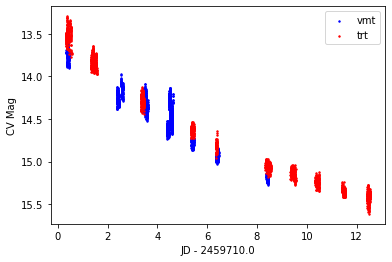

In [5]:
#plot mag vs JD

plt.scatter(JD_vmt,Mag_vmt,c='b',s=2,label="vmt")
plt.scatter(JD_trt,Mag_trt,c='r',s=2,label="trt")
plt.legend()
plt.gca().invert_yaxis()

plt.xlabel("JD - "+str(JD_0))
plt.ylabel("CV Mag")


In [6]:
#continuum fitting tools
import warnings
from specutils.spectra import Spectrum1D, SpectralRegion
from specutils.fitting import fit_generic_continuum
from astropy import units as u
from astropy.modeling.models import Chebyshev1D
from specutils.fitting.continuum import fit_continuum

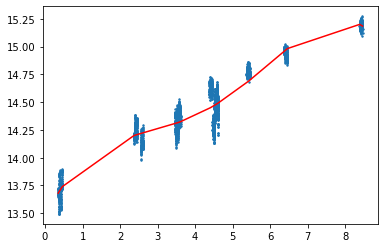

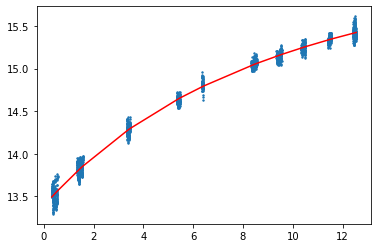

In [7]:
#fit the continuum: detrend

cont_region = [(0*u.m,13*u.m)]

with warnings.catch_warnings():  # Ignore warnings
        warnings.simplefilter('ignore')
        spectrum_vmt = Spectrum1D(flux=Mag_vmt*u.mag, spectral_axis=JD_vmt*u.m)
        spectrum_trt = Spectrum1D(flux=Mag_trt*u.mag, spectral_axis=JD_trt*u.m)
        continuum_vmt = fit_continuum(spectrum_vmt, window=cont_region, model=Chebyshev1D(4))
        continuum_trt = fit_continuum(spectrum_trt, window=cont_region, model=Chebyshev1D(4))
        Mag_detrend_vmt = Mag_vmt - continuum_vmt(JD_vmt*u.m).value
        Mag_detrend_trt = Mag_trt - continuum_trt(JD_trt*u.m).value

plt.scatter(JD_vmt,Mag_vmt,s=2)
plt.plot(JD_vmt,continuum_vmt(JD_vmt*u.m).value,c='r')
plt.figure()
plt.scatter(JD_trt,Mag_trt,s=2)
plt.plot(JD_trt,continuum_trt(JD_trt*u.m).value,c='r')



In [8]:
# split data into groups (by observing date)

vmt_data=dict(zip(JD_vmt,Mag_detrend_vmt))
obs_date_vmt=[0,2,3,4,5,6,8]
vmt_groups=[]
for i in range(len(obs_date_vmt)):
    vmt_groups.append({JD_vmt:Mag_vmt for JD_vmt,Mag_vmt in vmt_data.items() if (JD_vmt>obs_date_vmt[i] and JD_vmt<obs_date_vmt[i]+1)})

trt_data=dict(zip(JD_trt,Mag_detrend_trt))
obs_date_trt=[0,1,3,5,6,8,9,10,11,12]
trt_groups=[]
for i in range(len(obs_date_trt)):
    trt_groups.append({JD_trt:Mag_trt for JD_trt,Mag_trt in trt_data.items() if (JD_trt>obs_date_trt[i] and JD_trt<obs_date_trt[i]+1)})

[0.052290458091618336, 0.04346869373874776, 0.06460492098419685, 0.06379475895179036, 0.029713942788557712, 0.053820764152830575, 0.0698619723944789]
[0.055783156631326276, 0.056773354670934195, 0.05434286857371475, 0.0550990198039608, 0.1, 0.05659331866373276, 0.055243048609721956, 0.028507701540308066, 0.0644248849769954, 0.057331466293258665]


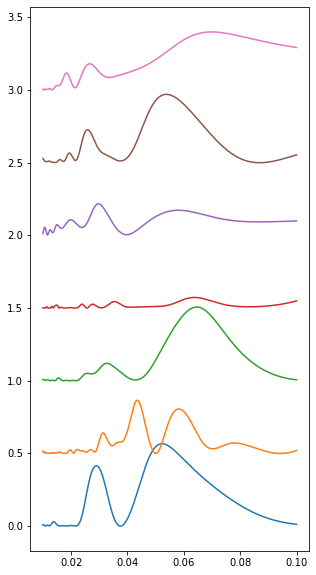

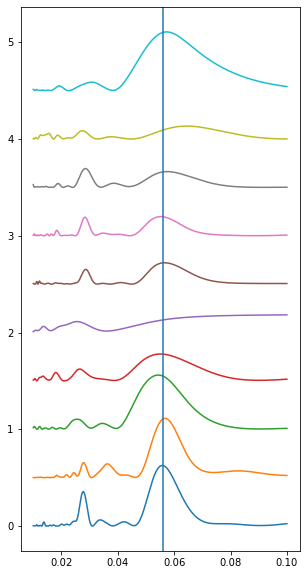

In [9]:
# LS periodogram for every obs day

periods=np.linspace(0.01,0.10,5000)
frequency=1.0/periods

period_vmt=[]
plt.rcParams['figure.figsize']=(5,10)
for i in range(len(obs_date_vmt)):
    power = LombScargle(list(vmt_groups[i].keys()), list(vmt_groups[i].values())).power(frequency)
    plt.plot(periods, power+0.5*i)
    period_vmt.append(periods[np.argmax(power)])

plt.figure()
period_trt=[]
for i in range(len(obs_date_trt)):
    power = LombScargle(list(trt_groups[i].keys()), list(trt_groups[i].values())).power(frequency)
    plt.plot(periods, power+0.5*i)
    period_trt.append(periods[np.argmax(power)])
plt.axvline(0.056)

print(period_vmt)
print(period_trt)


Text(0, 0.5, 'Relative Strength')

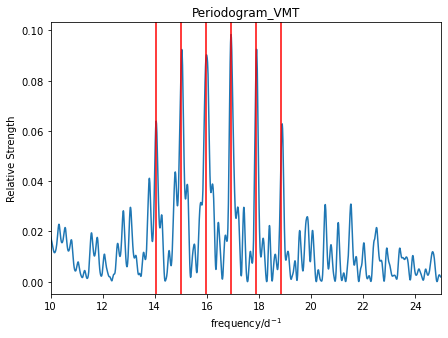

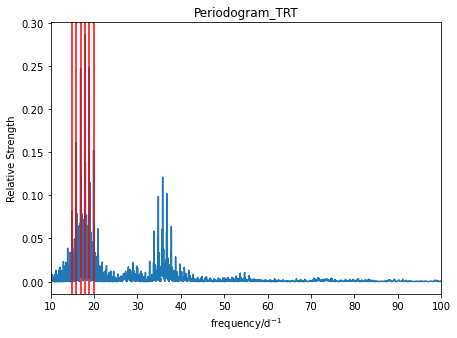

In [30]:
# LS periodogram for all data

plt.rcParams['figure.figsize']=(7,5)
power_vmt=LombScargle(JD_vmt,Mag_detrend_vmt).power(frequency)
power_trt=LombScargle(JD_trt,Mag_detrend_trt).power(frequency)
plt.plot(frequency,power_vmt,label="vmt")
plt.title("Periodogram_VMT")
# plt.xlim([10,25])
plt.xlim([10,100])
plt.axvline(14.05,c='r')
plt.axvline(15.01,c='r')
plt.axvline(15.97,c='r')
plt.axvline(16.93,c='r')
plt.axvline(17.89,c='r')
plt.axvline(18.85,c='r')
plt.xlabel("frequency/d$^{-1}$")
plt.ylabel("Relative Strength")
plt.figure()
plt.plot(frequency,power_trt,label="trt")
plt.title("Periodogram_TRT")
# plt.xlim([10,25])
plt.xlim([10,100])
plt.axvline(14.93,c='r')
plt.axvline(15.93,c='r')
plt.axvline(16.93,c='r')
plt.axvline(17.93,c='r')
plt.axvline(18.93,c='r')
plt.axvline(19.93,c='r')
plt.xlabel("frequency/d$^{-1}$")
plt.ylabel("Relative Strength")

